# Analysis of ``ad_hoc.dat`` for sink particles
### Do NOT run and update this notebook itself.   Instead, use the "Duplicate" option to make a copy, and run that!

Standard startup, with autoreload, which means edits of library procedures take effect immediately:

In [1]:
%load_ext autoreload
%autoreload 2
%pylab inline

Populating the interactive namespace from numpy and matplotlib


Alternative setup for XPython debug kernel:

#### Adjust these to your local setup:

In [2]:
top='c:/cygwin64/home/codes/dispatch2_clean/'
data='f:/data/'
experiment='ISM'
import os
os.chdir(top+'experiments/'+experiment+'/python')

Library packages:

In [3]:
import sys
lib=top+'utilities/python'
if sys.path[0] != lib:
    sys.path.insert(0,lib)
import dispatch as dis
import dispatch.select as dse
import dispatch.graphics as dgr
import dispatch.particles as dpa
from scipy.io import FortranFile

## DKD advantages
The drift-kick-drift (DKD) method offers some clear advantages in the DISPATCH context, since it allows two sink particles to be updated alternatingly, without any need for time-extrapolation of positions.  This is illustrated with a 2-particle solver below, after showing single-particle results  a modification of the single-particle procecdure here:

#### Single-particle code

In [4]:
GM=1.0
def mag(x):
    return sqrt(x[0]**2+x[1]**2)
def acc(r):
    r1=1./mag(r)
    return -GM*r1*r1*r1*r
def dkd(t,r,v,dt=0.1):
    r=r+0.5*dt*v     # drift 1
    a=acc(r)
    v=v+dt*a         # kick
    r=r+0.5*dt*v     # drift 2
    t=t+dt
    return t,r,v,a
def DKD(n,r0=1,v0=1,verbose=0):
    v_K=sqrt(GM/r0)
    P=2*pi*r0/v_K
    dt=P/n
    r=array([0.,r0])
    v=array([-v0,0.])
    t=0.0
    tt=[t]; rr=[r]; vv=[v]
    if verbose:
        print('sample data for n =',n)
    for i in range(n):
        t,r,v,a=dkd(t,r,v,dt)
        tt.append(t)
        rr.append(r)
        vv.append(v)
        if verbose>0 and i<10:
            print('  i={}   t={:.6e}   r={}   v={}  a={}'.format(i+1,t,r,v,a))
    rr=array(rr).transpose()
    plot(rr[0],rr[1],'-+'); plot(rr[0,0],rr[1,0],'o',label='0'); plot(rr[0,-1],rr[1,-1],'o',label='1')
    title('DKD n={}'.format(n)); legend();

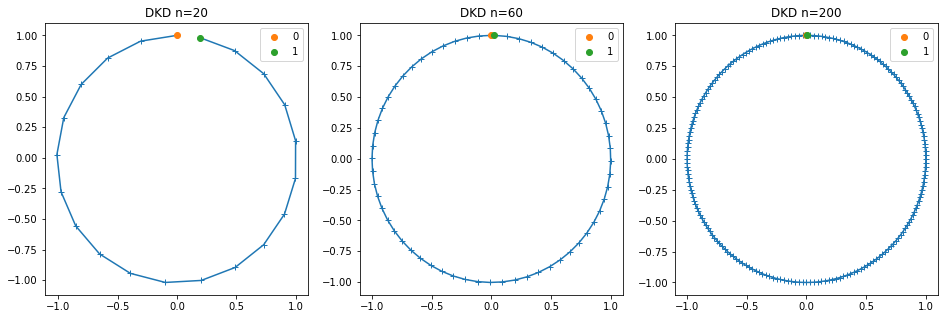

In [5]:
GM=1
figure(figsize=(16,5))
subplot(1,3,1); DKD(20)
subplot(1,3,2); DKD(60)
subplot(1,3,3); DKD(200)

``case1.nml`` parameters

M1=9.8329184e-03, a1=20.000, w1=20.000000, dt=0.001570796
M2=3.9331674e-02, a2=20.000, w2=20.000000
sample data for n = 200
  i=1   t=1.570796e-03   r=[-0.00157041  0.04997534]   v=[-0.9995067 -0.0314043]  a=[  0.31404303 -19.99260008]
  i=2   t=3.141593e-03   r=[-0.00313927  0.04990136]   v=[-0.9980273  -0.06277761]  a=[  0.94181891 -19.97286819]
  i=3   t=4.712389e-03   r=[-0.00470503  0.04977816]   v=[-0.99556324 -0.09408896]  a=[  1.56866456 -19.93342392]
  i=4   t=6.283185e-03   r=[-0.00626615  0.04960585]   v=[-0.99211698 -0.12530745]  a=[  2.19396087 -19.87430629]
  i=5   t=7.853982e-03   r=[-0.00782109  0.04938459]   v=[-0.9876919  -0.15640226]  a=[  2.81709024 -19.79557377]
  i=6   t=9.424778e-03   r=[-0.00936831  0.04911462]   v=[-0.98229239 -0.18734271]  a=[  3.43743725 -19.69730425]
  i=7   t=1.099557e-02   r=[-0.01090629  0.04879618]   v=[-0.97592377 -0.21809827]  a=[  4.0543892  -19.57959492]
  i=8   t=1.256637e-02   r=[-0.01243351  0.04842961]   v=[-0.96859233 -0.2486385

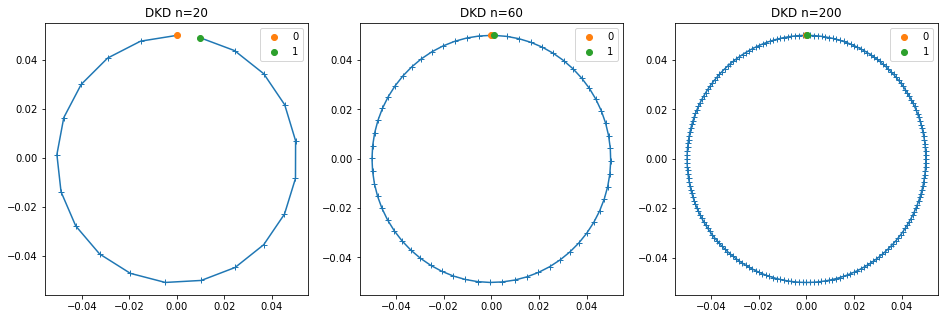

In [6]:
v0=1; r1=0.05; G=5.0849603133615489; 
M1=r1/G; GM=r1*v0**2
M2=4*M1; r2=2*r1
v1=  v0; a1=G*M1/r1**2
v2=2*v0; a2=G*M2/r2**2
aa1=G*M1/r1**3
aa2=G*M2/r2**3
w1=v1/r1
w2=a2/v1
n=200
dt=2*pi/(w1*n)
print('M1={:.7e}, a1={:.3f}, w1={:.6f}, dt={:.9f}'.format(M1,a1,w1,dt))
print('M2={:.7e}, a2={:.3f}, w2={:.6f}'.format(M2,a2,w2))
figure(figsize=(16,5))
subplot(1,3,1); DKD(20,r0=r1)
subplot(1,3,2); DKD(60,r0=r1)
subplot(1,3,3); DKD(200,r0=r1,verbose=1)

## DISPATCH case1 orbital elements

In [7]:
G=5.0849603133615489
M=0.05/1.594515**2
r=0.10
a=G*M/r**2
v=1.0
M=2*v**2*r/G
print('a:',a)
print('v:',v)
print('M:',M)

a: 10.000008147388906
v: 1.0
M: 0.03933167373488991


### Read procedure

In [8]:
class item():
    pass

def Read(run='',experiment='ISM'):
    name=data+experiment+'/'+run+'/ad_hoc.dat'
    sink={}
    with FortranFile(name) as fd:
        n=0
        while(1):
            n+=1
            try:
                id,nstep,dt,t,m,p,v,a=fd.read_record('i4,i4,f8,f8,f8,(3)f8,(3)f8,(3)f8')[0]
                if not id in sink.keys():
                    sink[id]=item()
                    s=sink[id]
                    s.t=[]
                    s.m=[]
                    s.p=[]
                    s.v=[]
                    s.a=[]
                s=sink[id]
                s.t.append(t)
                s.m.append(m)
                s.p.append(p)
                s.v.append(v)
                s.a.append(a)
            except:
                break
    for id in sink.keys():
        s=sink[id]
        s.t=array(s.t)
        s.m=array(s.m)
        s.p=array(s.p).transpose()
        s.v=array(s.v).transpose()
        s.a=array(s.a).transpose()
    print(n,'sink updates read')
    ids=list(sink.keys())
    ids.sort()
    print('sinks:',ids)
    return(sink)

## Case 1: Circular motion

In [9]:
run='case1'
sink=Read(run)

1279 sink updates read
sinks: [0, 1]


### Position time evolution

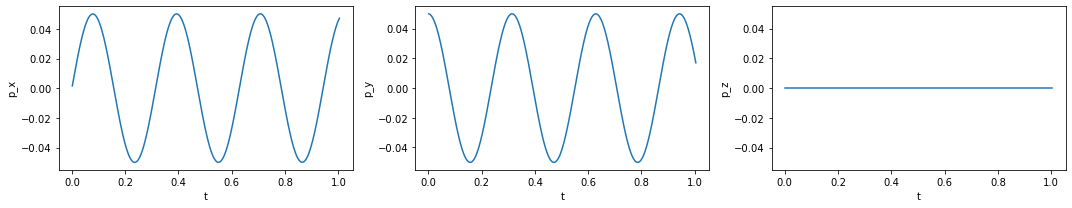

In [10]:
id=0
s=sink[id]
figure(figsize=(15,3))
subplot(1,3,1); plot(s.t,s.p[0]); xlabel('t'); ylabel('p_x');
subplot(1,3,2); plot(s.t,s.p[1]); xlabel('t'); ylabel('p_y');
subplot(1,3,3); plot(s.t,s.p[2]); xlabel('t'); ylabel('p_z');
tight_layout();

### Velocity time evolution

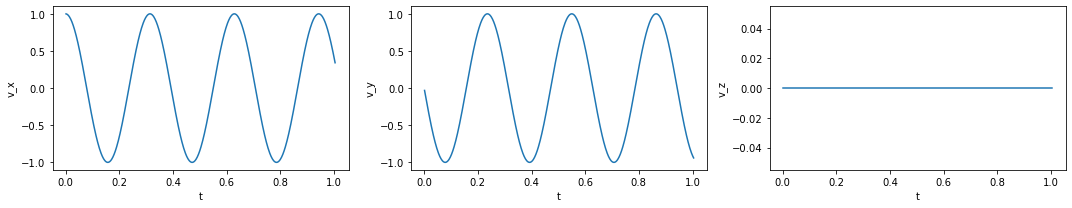

In [11]:
s=sink[id]
figure(figsize=(15,3))
subplot(1,3,1); plot(s.t,s.v[0]); xlabel('t'); ylabel('v_x');
subplot(1,3,2); plot(s.t,s.v[1]); xlabel('t'); ylabel('v_y');
subplot(1,3,3); plot(s.t,s.v[2]); xlabel('t'); ylabel('v_z');
tight_layout();

### Acceleration time evolution

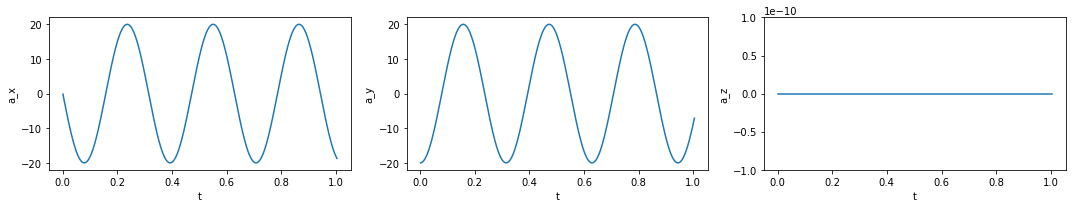

In [12]:
id=0
s=sink[id]
figure(figsize=(15,3))
subplot(1,3,1); plot(s.t,s.a[0]); xlabel('t'); ylabel('a_x');
subplot(1,3,2); plot(s.t,s.a[1]); xlabel('t'); ylabel('a_y');
subplot(1,3,3); plot(s.t,s.a[2]); xlabel('t'); ylabel('a_z'); ylim(-1e-10,1e-10);
tight_layout();

### Phase plots

In [79]:
def RD(run,wp=0.06,wv=2.5,wa=200,ms=1):
    sink=Read(run)
    figure(figsize=(15,4.5))
    period=2*pi*0.05
    s=sink[0]
    orbits=s.t[-1]/period
    txt='{}   {:.1f} circular orbits'.format(run,orbits)
    txt='{}'.format(run)
    cmap=get_cmap("tab10")
    def lim(w=0.06):
        xlim(-w,w); ylim(-w,w)
    subplot(1,3,1); 
    for id in sink.keys():
        s=sink[id]; plot(s.p[0],s.p[1],'o',ms=ms)
        plot(s.p[0,0],s.p[1,0],'o',color=cmap(id)); 
        plot(s.p[0,-1],s.p[1,-1],'o',color=cmap(id),label=id)
    xlabel('p_x'); ylabel('p_y'); legend(); title(txt); lim(wp)

    subplot(1,3,2)
    for id in sink.keys():
        s=sink[id]; plot(s.v[0],s.v[1],'o',label=id,ms=ms); legend(); title(txt)
        plot(s.p[0,0],s.p[1,0],'o',color=cmap(id)); 
        plot(s.p[0,-1],s.p[1,-1],'o',color=cmap(id),label=id)
    xlabel('v_x'); ylabel('v_y'); lim(wv)

    subplot(1,3,3)
    for id in sink.keys():
        s=sink[id]; plot(s.a[0],s.a[1],'o',label=id,ms=ms); legend(); title(txt)
        plot(s.p[0,0],s.p[1,0],'o',color=cmap(id)); 
        plot(s.p[0,-1],s.p[1,-1],'o',color=cmap(id),label=id)
    xlabel('a_x'); ylabel('a_y'); lim(wa);

1279 sink updates read
sinks: [0, 1]


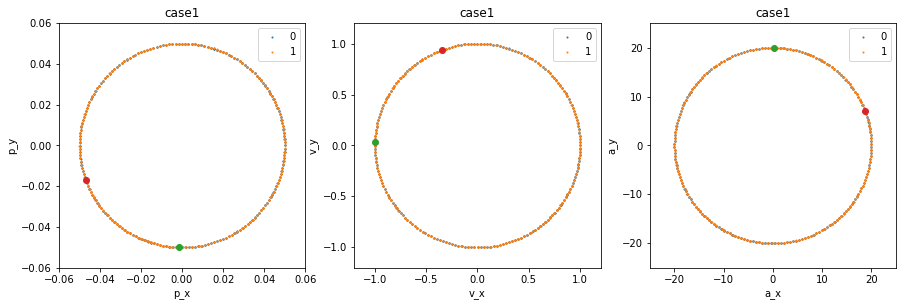

In [14]:
RD('case1',0.06,1.2,25)

## Case 2: Eccentric binary, about 6 orbits

5912 sink updates read
sinks: [0, 1]


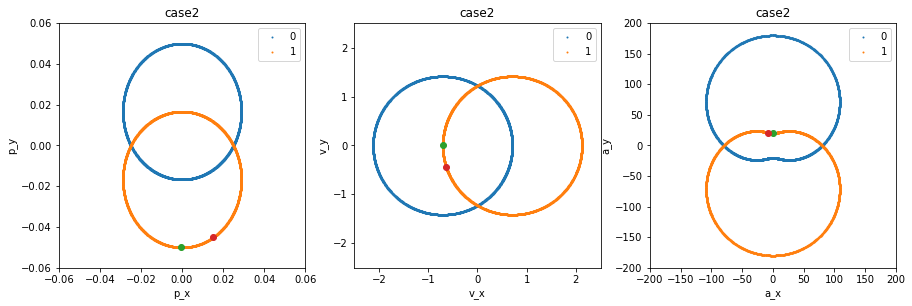

In [15]:
RD('case2',0.06,2.5,200)

## Case 3: About 60 orbits

29313 sink updates read
sinks: [0, 1]


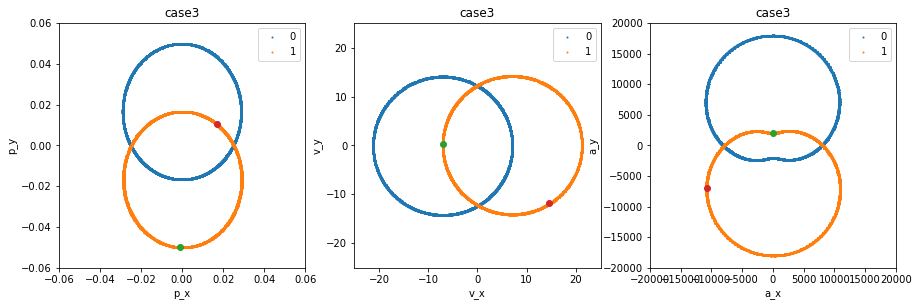

In [16]:
RD('case3',0.06,25,20000)

In [17]:
def ACC(run,tmax=0.1):
    sink=Read(run)
    id=0
    s=sink[id]
    figure(figsize=(15,3))
    subplot(1,3,1); plot(s.t,s.a[0]); xlabel('t'); ylabel('a_x'); xlim(0,tmax)
    subplot(1,3,2); plot(s.t,s.a[1]); xlabel('t'); ylabel('a_y'); xlim(0,tmax)
    subplot(1,3,3); plot(s.t,s.a[2]); xlabel('t'); ylabel('a_z'); ylim(-1e-10,1e-10);
    tight_layout();

29313 sink updates read
sinks: [0, 1]


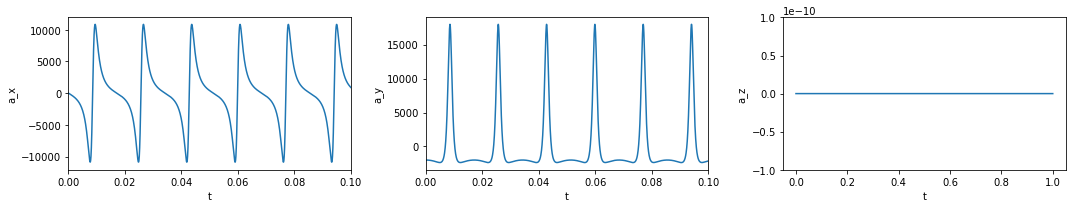

In [18]:
ACC('case3')

## Case 4: Approximately 600 orbits

293262 sink updates read
sinks: [0, 1]


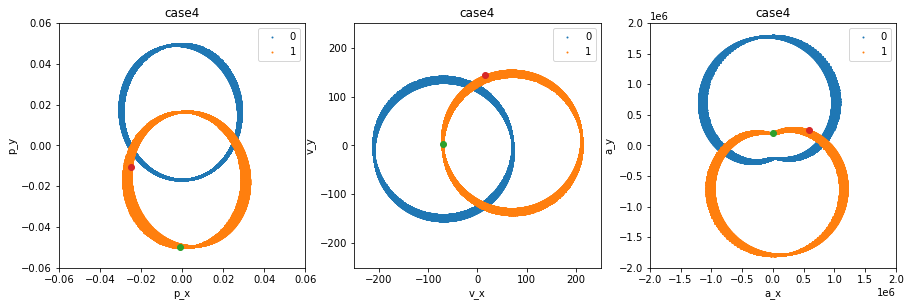

In [19]:
RD('case4',0.06,250,2000000)

In [21]:
sink=Read('case4')
t0=sink[0].t
t1=sink[1].t

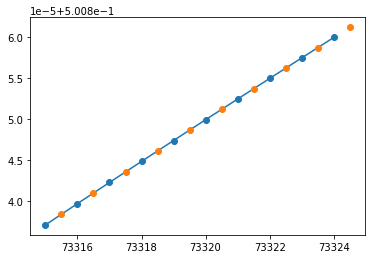

In [22]:
n=10
i=len(t0)//2
it=i+arange(10)
plot(it,t0[i:i+n],'-o')
plot(it+.5,t1[i:i+n],'o');

## Case 5: Case 2 + two introduding sinks

15483 sink updates read
sinks: [0, 1, 2, 3]


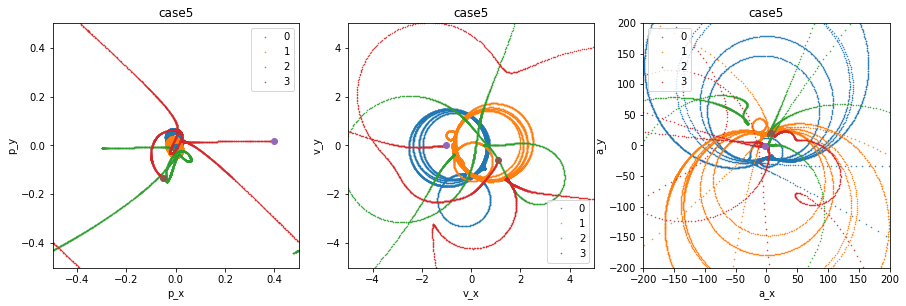

In [23]:
RD('case5',0.5,5,200,ms=.5)

### The fate of the green sink

In [27]:
sinks=Read('case5')

15483 sink updates read
sinks: [0, 1, 2, 3]


15483 sink updates read
sinks: [0, 1, 2, 3]


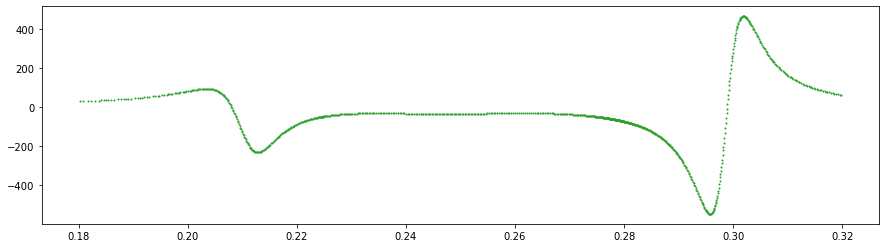

In [24]:
green=sinks[2]
t=green.t
w=where(abs(t-0.25)< 0.07)[0]
cmap=get_cmap("tab10")
figure(figsize=(15,4))
plot(t[w],green.a[0,w],'o',ms=1,color=cmap(2));

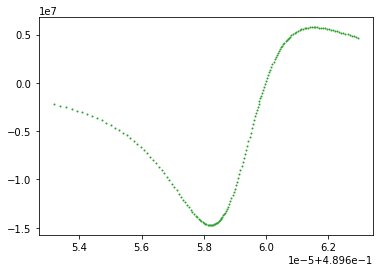

In [25]:
w=where(abs(t-0.489658) < 5e-6)[0]
plot(t[w],green.a[0,w],'o',ms=1,color=cmap(2));

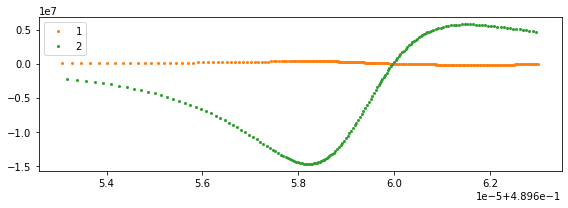

In [55]:
figsize=(8,3); figure(figsize=figsize)
for i in (1,2):
    t=sinks[i].t; w=where(abs(t-0.489658) < 5e-6)[0]
    plot(t[w],sinks[i].a[0,w],'o',ms=2,color=cmap(i),label=i)
legend(); tight_layout();

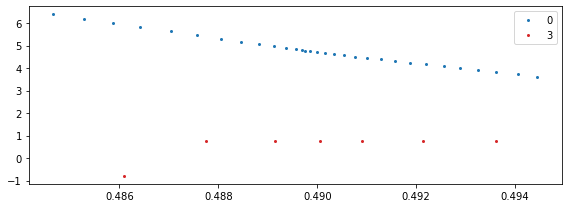

In [56]:
figure(figsize=figsize)
for i in (0,3):
    t=sinks[i].t; w=where(abs(t-0.489658) < 5e-3)[0]
    plot(t[w],sinks[i].a[0,w],'o',ms=2,color=cmap(i),label=i)
legend(); tight_layout();

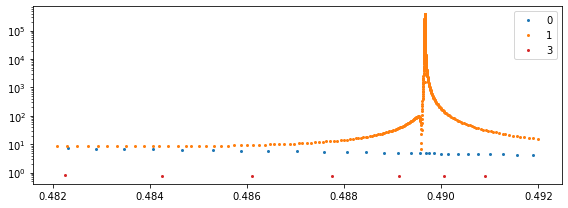

In [73]:
figure(figsize=figsize)
for i in (0,1,3):
    t=sinks[i].t; w=where(abs(t-0.487) < 5e-3)[0]
    semilogy(t[w],abs(sinks[i].a[0,w]),'o',ms=2,color=cmap(i),label=i)
legend(); tight_layout();

## Case 6: Two interacting binaries

36211 sink updates read
sinks: [0, 1, 2, 3]


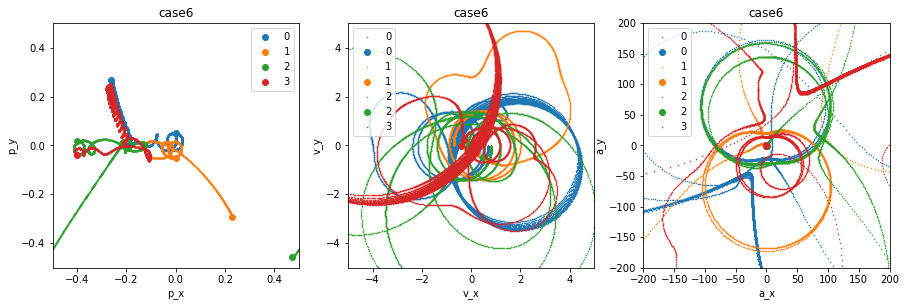

In [80]:
RD('case6',0.5,5,200,ms=.5)

The cell below is added to prevent scrolling when executing the cell above

In [26]:
for i in range(33): print('')